# 꽃 종류, 색상 분류
- xml파일 파싱

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm.notebook import tqdm

import xml.etree.ElementTree as ET

import torch
import torchvision.transforms as T
import torchvision.models as models

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
device = 'mps'

# xml 파일 파싱

In [8]:
def xml_parsing(xml_path):
    filename_list = []
    label_list = []

    # xml 파일 불러오기
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # 이미지 파일명과 라벨 추출
    for image in root.findall('image'):
        filename = image.find('filename').text
        filename_list.append(filename)

        labels = [label.text for label in image.find('labels')]
        label_list.append(labels)
    
    return filename_list, label_list

data_root = '/Users/kimhongseok/cv_79_projects/part1/chapter3/3/data'
image_dir = 'images'
annotaion_filename = 'annotations.xml'
annotation_path = os.path.join(data_root, annotaion_filename)

filename_list, label_list = xml_parsing(annotation_path)
print(filename_list[:2])
print(label_list[:2])

['white_rose_116.jpg', 'white_rose_96.jpg']
[['white', 'rose'], ['white', 'rose']]


In [9]:
from collections import defaultdict

def get_class_map(label_list):
    cls_map = defaultdict(int)
    for labels in label_list:
        for l in labels:
            cls_map[l] += 1

    return cls_map

cls_map = get_class_map(label_list)
cls_map

defaultdict(int,
            {'white': 492,
             'rose': 502,
             'yellow': 542,
             'tulip': 532,
             'red': 556,
             'chrysanthemum': 556})

In [6]:
class_list = list(cls_map.keys())
columns = ['filename'] + class_list
annotations = pd.DataFrame(columns=columns)
annotations

Empty DataFrame
Columns: [filename, white, rose, yellow, tulip, red, chrysanthemum]
Index: []

In [7]:
for idx, (filename, labels) in enumerate(zip(filename_list, label_list)):
    row = {}
    row['filename'] = filename

    for cls in class_list:
        if cls in labels:
            row[cls] = 1
        else :
            row[cls] = 0

    annotations.loc[idx] = row

In [8]:
annotations

filename  white  rose  yellow  tulip  red  \
0            white_rose_116.jpg      1     1       0      0    0   
1             white_rose_96.jpg      1     1       0      0    0   
2            white_rose_102.jpg      1     1       0      0    0   
3             white_rose_69.jpg      1     1       0      0    0   
4             white_rose_55.jpg      1     1       0      0    0   
...                         ...    ...   ...     ...    ...  ...   
1585   red_chrysanthemum_76.jpg      0     0       0      0    1   
1586   red_chrysanthemum_62.jpg      0     0       0      0    1   
1587  red_chrysanthemum_100.jpg      0     0       0      0    1   
1588  red_chrysanthemum_128.jpg      0     0       0      0    1   
1589   red_chrysanthemum_89.jpg      0     0       0      0    1   

      chrysanthemum  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
1585              1  
1586              1  
1587              1  
1588              1  
1589              1  

[1590 rows x 7 columns]

In [9]:
annotations.to_csv('/Users/kimhongseok/cv_79_projects/part1/chapter3/3/data/annotations.csv', index=False)

In [10]:
annotations.sum()

filename         white_rose_116.jpgwhite_rose_96.jpgwhite_rose_...
white                                                          492
rose                                                           502
yellow                                                         542
tulip                                                          532
red                                                            556
chrysanthemum                                                  556
dtype: object

# CustomDataset

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, data_df, classes, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms
        self.classes = classes
        data_num = data_df.shape[0]

        for i in range(data_num):
            img_name = data_df.iloc[i, 0]
            img_path = os.path.join(root_dir, img_name)
            labels = []
            for j in range(1, 7):
                if data_df.iloc[i, j] == 1:
                    labels.append(j-1)

            self.data.append((img_path, labels))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        labels = self.data[idx][1]
        labels = torch.nn.functional.one_hot(torch.tensor(labels), len(self.classes)).sum(dim=0).to(torch.float)

        return img, labels

In [6]:
annotations = pd.read_csv('/Users/kimhongseok/cv_79_projects/part1/chapter3/3/data/annotations.csv')
annotations

filename  white  rose  yellow  tulip  red  \
0            white_rose_116.jpg      1     1       0      0    0   
1             white_rose_96.jpg      1     1       0      0    0   
2            white_rose_102.jpg      1     1       0      0    0   
3             white_rose_69.jpg      1     1       0      0    0   
4             white_rose_55.jpg      1     1       0      0    0   
...                         ...    ...   ...     ...    ...  ...   
1585   red_chrysanthemum_76.jpg      0     0       0      0    1   
1586   red_chrysanthemum_62.jpg      0     0       0      0    1   
1587  red_chrysanthemum_100.jpg      0     0       0      0    1   
1588  red_chrysanthemum_128.jpg      0     0       0      0    1   
1589   red_chrysanthemum_89.jpg      0     0       0      0    1   

      chrysanthemum  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
1585              1  
1586              1  
1587              1  
1588              1  
1589              1  

[1590 rows x 7 columns]

In [10]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

shuffled_annotations = annotations.sample(frac=1).reset_index(drop=True)
classes = list(cls_map.keys())

total_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter3/3/data/images', shuffled_annotations, classes, transforms)

In [11]:
classes

['white', 'rose', 'yellow', 'tulip', 'red', 'chrysanthemum']

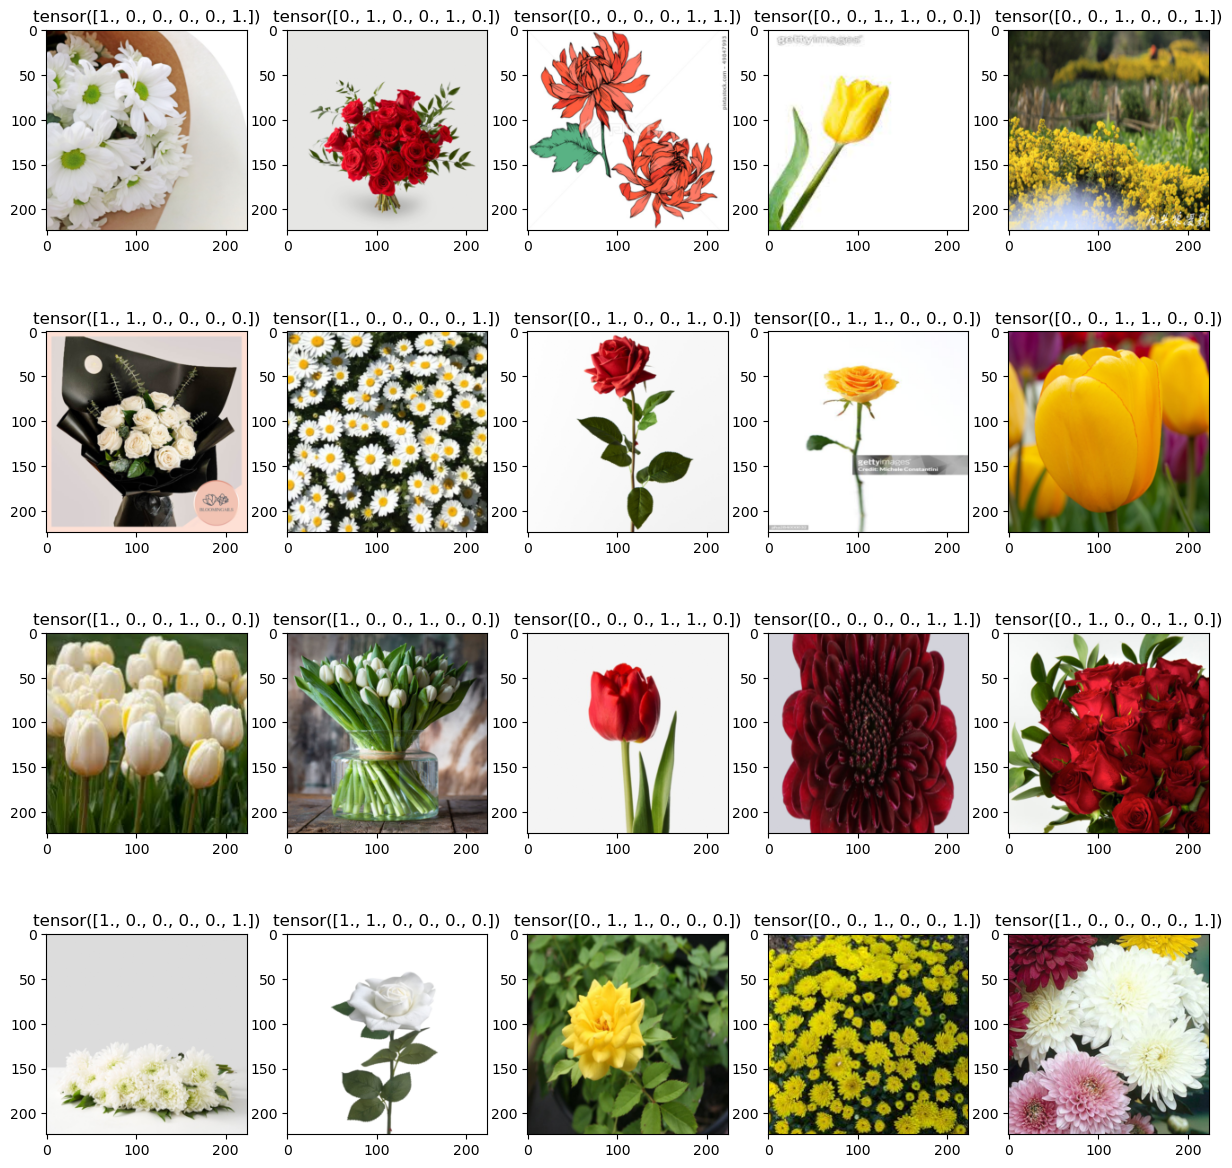

In [30]:
plt.figure(figsize=(15, 15))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(total_dataset[i][0].permute(1, 2, 0))
    plt.title(total_dataset[i][1])

In [31]:
total_num = len(total_dataset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_num, valid_num, test_num])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

# train

In [37]:
def training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    total_labels = []
    total_preds = []

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > threshold).float()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_f1 = f1_score(total_preds, total_labels, average='micro')

    return model, train_loss, train_f1

def evaluation(model, valid_dataloader, criterion, trhreshold, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0

    total_labels = []
    total_preds = []
    
    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs)>trhreshold).float()
            loss = criterion(outputs, labels)

            valid_loss += loss.item()

            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_f1 = f1_score(total_labels, total_preds, average='micro')

    return model, valid_loss, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, threshold, num_epochs):
    model.to(device)

    for epoch in range(num_epochs):
        model, train_loss, train_f1 = training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs)
        model, valid_loss, valid_f1 = evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train F1: {train_f1}, Valid Loss: {valid_loss}, Valid F1: {valid_f1}')

    return model

# model

In [33]:
model = models.resnet50(pretrained=True)
model

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [34]:
for param in model.parameters():
    param.requires_grad = False

In [35]:
model.fc = torch.nn.Linear(in_features=2048, out_features=len(classes), bias=True)

for param in model.fc.parameters():
    param.requires_grad = True

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, 0.5, 10)

  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.4636229246854782, Train F1: 0.6067754077791718, Valid Loss: 0.2922588586807251, Valid F1: 0.8847457627118643


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.2603951200842857, Train F1: 0.8822044594026083, Valid Loss: 0.20666430294513702, Valid F1: 0.9290322580645162


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.21623890586197375, Train F1: 0.9029225424075209, Valid Loss: 0.17395964562892913, Valid F1: 0.9245901639344262


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.17468965891748667, Train F1: 0.923076923076923, Valid Loss: 0.14414361417293547, Valid F1: 0.9480519480519481


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.16407811269164085, Train F1: 0.9232009675468654, Valid Loss: 0.14072436094284058, Valid F1: 0.9465408805031447


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.14740522261708974, Train F1: 0.9337071900660925, Valid Loss: 0.12140605002641677, Valid F1: 0.964968152866242


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.13185163643211126, Train F1: 0.9416932907348242, Valid Loss: 0.11410595029592514, Valid F1: 0.9602543720190778


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.1284415429458022, Train F1: 0.9407067278897984, Valid Loss: 0.11320737153291702, Valid F1: 0.9537480063795853


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.12330867983400821, Train F1: 0.9423268808621035, Valid Loss: 0.10813395529985428, Valid F1: 0.957345971563981


  0%|          | 0/40 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Train Loss: 0.11579038463532924, Train F1: 0.9486009128795395, Valid Loss: 0.10088717490434647, Valid F1: 0.9603803486529319


# test

In [40]:
model.eval()
total_labels = []
total_preds = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs)>0.5).int()

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

print(f1_score(total_labels, total_preds, average='micro'))

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


0.9537480063795853


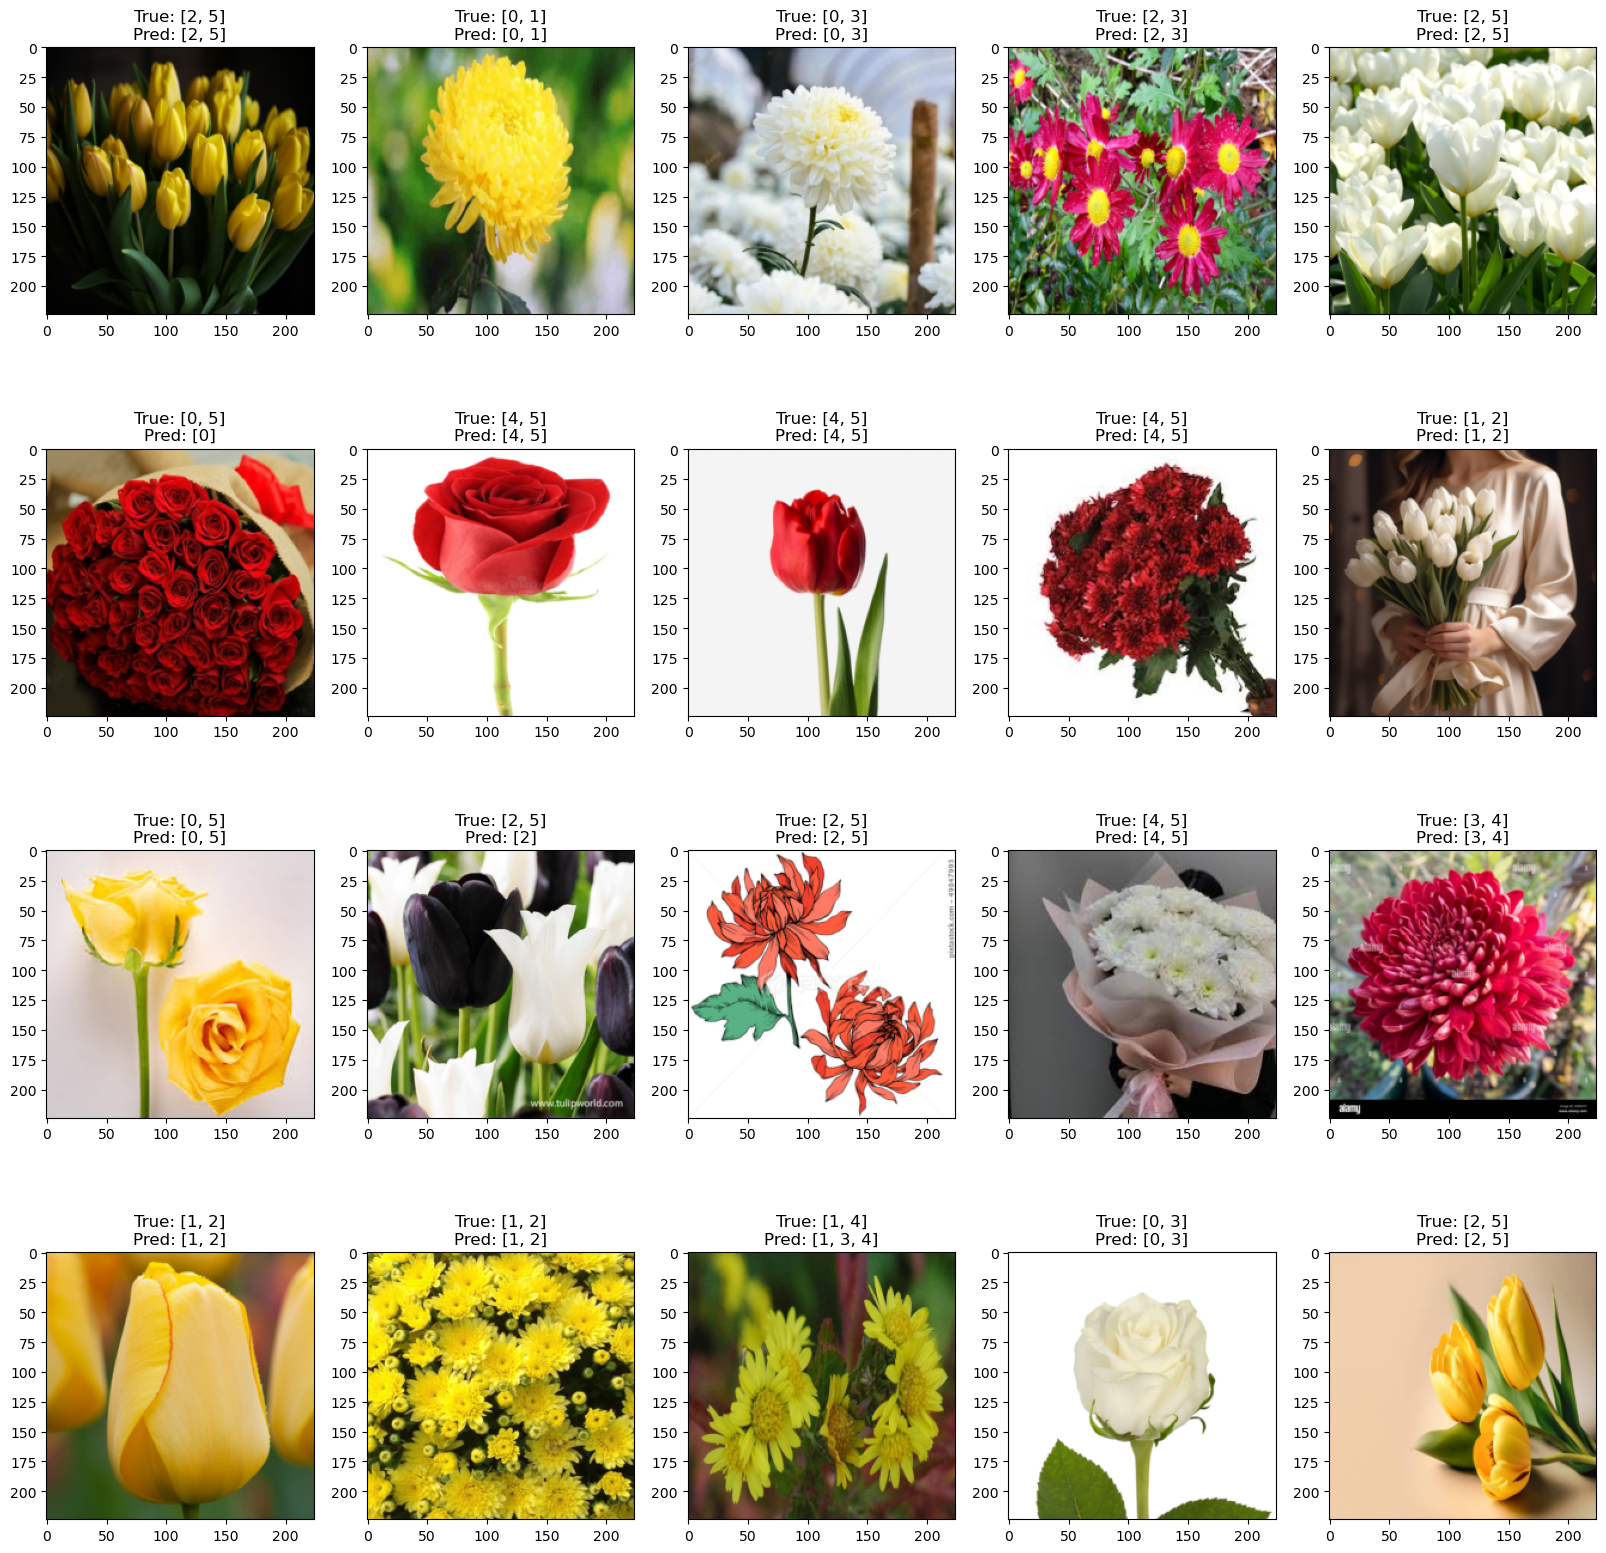

In [42]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    labels = []
    preds = []

    for j in range(len(classes)):
        if total_labels[i][j] == 1:
            labels.append(j)

        if total_preds[i][j] == 1:
            preds.append(j)

    plt.title(f'True: {labels}\nPred: {preds}')